# Package loading

In [1]:
import numpy as np
import pandas as pd
import os
import shapely
from shapely.geometry.point import Point
from shapely.geometry import Polygon, LineString, Point
import dxfgrabber as dxfgb
import matplotlib.pyplot as plt
import math

# Sub features

In [2]:
def plot_dxf(dxfdetails):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    for closedsection in dxfdetails['closed_patterns']:
        poly = Polygon(closedsection)
        x, y = poly.exterior.xy
        plt.plot(x, y, color='g', alpha=0.5)
    
    for opensection in dxfdetails['open_patterns']:
        lines = LineString(opensection)
        x, y = lines.xy
        plt.plot(x, y, color='y', alpha=1)
    
    for bendlines, tangents in zip(dxfdetails['bend_line'], dxfdetails['tangents_coords']):
        lines = LineString(bendlines)
        color = (np.random.rand(),np.random.rand(),np.random.rand())
        x, y = lines.xy
        plt.plot(x, y, color=color)
        for tangent in tangents:
            lines = LineString(tangent)
            x, y = lines.xy
            plt.plot(x, y, color=color)
    
    centeraxis = dxfdetails['bend_center']
    for center, angle, direction, radius in zip(centeraxis,
                                               dxfdetails['bend_angle'],
                                               dxfdetails['bend_direction'],
                                               dxfdetails['bend_radius']):
        ax.text(center[0], center[1], '{} - {} - {}'.format(angle, direction, radius), color='c')
        
    
    poly = Polygon(dxfdetails['minimum_rectangle_coords'])
    x, y = poly.exterior.xy
    plt.plot(x, y, color='r')
    
    poly = Polygon(dxfdetails['convex_hull_coords'])
    x, y = poly.exterior.xy
    plt.plot(x, y, color='b')
    
    ax.set_aspect('equal')
    #ax.set_xlim([345,355])
    #ax.set_ylim([95,105])
    plt.show()
    
#plot_dxf(details)

In [3]:
#Calculates the angle of a line
def angleline(linestring):
    xs, xe = linestring.xy[0]
    ys, ye = linestring.xy[1]
    
    if xs == xe:
        angle = np.pi/2
    else:
        angle = np.arctan((ye-ys)/(xe-xs))
    
    return math.degrees(angle)

a = LineString(((0,0), (-1,-1)))
b = LineString(((1,1), (0,0)))
angleline(a)

45.0

In [4]:
a = LineString(((1,1), (0,0)))
def extendline(line, length):
    #Line angle calculation
    xs, xe = line.xy[0]
    ys, ye = line.xy[1]


    if xs == xe:
        if ye < ys:
            xe, ye, xs, ys = xs, ys, xe, ye
        return LineString(((xs, ys-length), (xe, ye+length)))
    else:
        if xe > xs:
            xe, ye, xs, ys = xs, ys, xe, ye
        angle = np.arctan((ye-ys)/(xe-xs))
        return LineString(((xs+np.cos(angle)*length, ys+np.sin(angle)*length*np.sign(angle)), (xe-np.cos(angle)*length, ye-np.sin(angle)*length*np.sign(angle))))


extendline(a,1).xy

(array('d', [1.7071067811865475, -0.7071067811865476]),
 array('d', [1.7071067811865475, -0.7071067811865475]))

In [5]:
def cut(line, distance):
    # Cuts a line in two at a distance from its starting point
    if distance <= 0.0 or distance >= line.length:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]

In [6]:
data=list(Polygon(((1,1), (0,0), (1,0))).exterior.coords)
data

[(1.0, 1.0), (0.0, 0.0), (1.0, 0.0), (1.0, 1.0)]

In [7]:
[(cell,data[index+1]) for index, cell in enumerate(data[:-1])]

[((1.0, 1.0), (0.0, 0.0)), ((0.0, 0.0), (1.0, 0.0)), ((1.0, 0.0), (1.0, 1.0))]

# Package documentation

http://dxfgrabber.readthedocs.io/en/latest/  
https://shapely.readthedocs.io/en/latest/

# DXF loading

In [63]:
#List of all the dixs in the folder
dxffolder = os.path.join('/', *os.getcwd().split('/')[:-1], 'Sample')
dxflist = [os.path.join(dxffolder, file) for file in os.listdir(dxffolder) if file.endswith('.dxf')]
for index, path in enumerate(dxflist):
    print(index, path.split('/')[-1])

0 l1614570_flat1.dxf
1 l1616010_flat1.dxf
2 l1616170_flat1.dxf
3 l2500700_flat1.dxf
4 l2503310_flat1.dxf
5 l2507330_flat1.dxf
6 l2510670_flat1.dxf
7 l2512270_flat1.dxf
8 l2512980_flat1.dxf
9 l2518910_flat1.dxf
10 l2522110_flat1.dxf
11 l2603320_flat1.dxf
12 l2606540_flat1.dxf
13 l2607640_flat1.dxf
14 l2607690_flat1.dxf
15 l2608450_flat1.dxf
16 l2609830_flat1.dxf
17 l2701680_flat1.dxf
18 l2703550_flat1.dxf
19 l3006650_flat1.dxf
20 l3007020_flat1.dxf
21 l3009013_flat1.dxf
22 x0495337_flat1.dxf


In [299]:
dxflist[3].split('/')[-1][1:3]

'25'

In [337]:
dxf = dxfgb.readfile(dxflist[3])
print(dxf.dxfversion)
#for element in [element for element in dxf.modelspace()]: #   if element.dxftype == 'MTEXT'
#for element in [element for element in dxf.modelspace() if element.dxftype == 'MTEXT']: #
for element in [element for element in dxf.modelspace() if element.layer == 'NOTES' and element.dxftype == 'TEXT']: #
#for element in [element for element in dxf.modelspace() if element.linetype == 'PHANTOM']:
    #print(np.round(x.start,3))
    print(element)
    #print(element.color)
    #print(element.dxftype)
    try:
        print(element.text, '-',  element.insert, element.align_point, element.halign)
    except:
        pass
    try:
        print(element.points)
        print(element.is_closed)
    except:
        pass
    try:
        print(element.plain_text(split=False))
        #for line in element.plain_text(split=False).split('\n'):
        #    print(line.split(':'))
        #    print()
        #print(element.lines())
        #print(element.insert)
    except:
        pass
    #print(element.linetype)
    #
    #print(element.insert)
    #print(element.center, element.major_axis, element.ratio, element.start_param, element.end_param)
    #print(np.round(element.control_points, 3)[:,0:2])
    print()

AC1015
TEXT [20F]
THICKNESS:  - (0.0, -1.75) None 0

TEXT [210]
8 - (32.725, -1.75) None 0

TEXT [211]
UNITES:  - (0.0, -7.0) None 0

TEXT [212]
Millimetre / Kilogramme - (23.8, -7.0) None 0

TEXT [213]
MATIERE:  - (0.0, -12.25) None 0

TEXT [214]
S355MC - (26.775, -12.25) None 0

TEXT [215]
RAYON:  - (0.0, -17.5) None 0

TEXT [216]
8 - (20.825, -17.5) None 0

TEXT [217]
ECHELLE   - (172.2456936643, -129.4304318497) (199.0206936643, -129.4304318497) 2

TEXT [218]
1 - (199.0206936643, -129.4304318497) (201.9956936643, -129.4304318497) 2

TEXT [219]
13 - (201.9956936643, 148.1699174744) None 0

TEXT [21A]
 TROUSS - (207.9456936643, 148.1699174744) None 0

TEXT [21B]
4 - (1917.2456936643, 196.9199174744) None 0

TEXT [21C]
 TROUS - (1920.2206936643, 196.9199174744) None 0

TEXT [21D]
4 - (1965.9956936643, 148.1699174744) None 0

TEXT [21E]
 TROUS - (1968.9706936643, 148.1699174744) None 0

TEXT [21F]
2 - (2186.4956936643, 148.1702667985) None 0

TEXT [220]
 COUPES - (2189.4706936643, 148.

# DXF reading module

In [265]:
mask = np.array([True,False,True])
np.array([1,2,3])[mask]

array([1, 3])

In [320]:
class DxfParser():
    def __init__(self, edge_color=[3, 7], #List of possible colors for cuted edges
                 etching_color=2,
                 min_edge_length=.5, #Maximum length for ARCS and ELLIPSE
                 roundigexp=3, #Number of digits to keep
                 max_distance_correction=.75, #Maximum distance to close open loops
                ):
        """Class parameters definition"""
        self.min_edge_length = min_edge_length
        self.etching_color = etching_color
        self.edge_color = edge_color
        self.roundigexp = roundigexp
        self.details = {}
        self.color = 0 #Will be updated each time we load a new dxf file
        self.max_distance_correction = max_distance_correction
        
    
    def load_dxf(self, dxfpath):
        """Loads the DXF file"""
        self.dxf = dxfgb.readfile(dxfpath)
        
        #Most common color calculation
        colors = [element.color for element in self.dxf.modelspace() if element.linetype == 'CONTINUOUS']
        self.color = np.argmax(np.bincount(colors))
        
        #Note reading
        notes = [element for element in self.dxf.modelspace() if element.layer == 'NOTES' and element.dxftype == 'TEXT']
        
        bend_angle = []
        bend_direction = []
        bend_radius = []
        bend_center = []
        
        for note in notes:
            rawnote = note.text
            coord = note.insert
            #lists all the notes on the same line after the current note
            possiblevalue = [x for x in notes if coord[1]==x.insert[1] and coord[0]<x.insert[0]]
            distances = [Point(x.insert).distance(Point(coord)) for x in possiblevalue]
            index = np.argsort(distances)# if len(distances) !=0 else None
            if rawnote.startswith('THICKNESS:'): #It's the thickness
                try:
                    self.details['thickness'] = float(possiblevalue[index[0]].text)
                except:
                    self.details['thickness'] = np.nan
            elif rawnote.startswith('UNITES:'):#It's the unit
                self.details['unit'] = possiblevalue[index[0]].text
            elif rawnote.startswith('MATIERE'): #It's the material
                self.details['material'] = possiblevalue[index[0]].text
            elif rawnote.startswith('RAYON'): #It's the general radius
                try:
                    self.details['radius'] = float(possiblevalue[index].text)
                except:
                    self.details['radius'] = np.nan
            elif rawnote == 'UP' or rawnote == 'DOWN': #It's a bend
                x,y = coord
                if rawnote == 'UP':
                    coordtext = (x-6.25,y-4.25)
                elif rawnote == 'DOWN':
                    coordtext = (x,y-1.5)
                else:
                    coordtext = (x-6.25,y)
                
                bend_direction.append(rawnote)
                bend_angle.append(float(possiblevalue[index[0]].text))
                bend_radius.append(float(possiblevalue[index[3]].text))
                bend_center.append(coordtext)

                

        self.details['bend_angle'] = bend_angle
        self.details['bend_direction'] = bend_direction
        self.details['bend_radius'] = bend_radius
        self.details['bend_center'] = bend_center
    
    def _bend_placement(self, limit_distance=1):
        """Populates information such as nuber of bends, direction"""
        axis = []
        tangents_coords = []
        
        #List of axis creation
        tangents = [(element.start, element.end) for element in self.dxf.modelspace() if element.linetype == 'PHANTOM']
        tangentsangles = [np.round(angleline(LineString(tangentcoord)), self.roundigexp) for tangentcoord in tangents]
        print(tangentsangles)
        possible_axis = [element for element in self.dxf.modelspace() if element.linetype == 'CENTER' and element.dxftype == 'LINE' ]
        centeraxis = [list(LineString((x.start, x.end)).interpolate(0.5, normalized=True).coords)[0] for x in possible_axis]
        
        #Candidate bend lines
        possible_bendline = [element for element in possible_axis if np.round(angleline(LineString((element.start, element.end))), self.roundigexp) in tangentsangles]
        
        #Conversion to coordinates
        for lines in possible_bendline:
            segment = np.round((lines.start, lines.end), decimals=self.roundigexp)[:,0:2]
            axis.append(tuple(map(tuple, segment)))
        
        bend_index = []
        
        for angle, radius, center in zip(self.details['bend_angle'], self.details['bend_radius'], self.details['bend_center']):
            #L= angle*R+(0.1594*ln(R/T)+0.51722)*T   
            thickness = self.details['thickness']
            #Flat lengthcenteraxis
            flatdistance = np.radians(angle)*radius+(0.1594*math.log(radius/thickness,math.exp(1))+0.51722)*thickness
            
            #select the axes the n-best axes according the note
            axisdist = [(LineString(x).distance(Point(center)))**2 for x in axis]
            sort_index = np.argsort(axisdist)
            
            #Searching of the tangent line associated with te bend
            for indexposition in sort_index:
                print(axisdist[indexposition])
                candidate_axis = axis[indexposition]
                angle_candidate = np.round(angleline(LineString(candidate_axis)), self.roundigexp)
                tangents_candidates = [x for x in tangents if angle_candidate==np.round(angleline(LineString(x)), self.roundigexp)]
                extended_tangents = [self.extendline(LineString(x), self.details['minimum_rectangle_dim1']*2) for x in tangents_candidates]
                distances = [(LineString(x).distance(Point(center))) for x in extended_tangents]
                #print(indexposition, distances, candidate_axis, len(tangents_candidates), angle_candidate)
                mask = np.array(distances)<limit_distance+flatdistance/2
                if np.any(mask):
                    bend_index.append(indexposition)
                    tangents_coords.append(np.array(tangents_candidates)[mask])
                    break
            else:
                print('NOK')
                bend_index.append(sort_index[0])
                tangents_coords.append([])
                


        self.details['bend_line'] = [axis[k] for k in bend_index]
        self.details['tangents_coords'] = tangents_coords
        #self.details['bend_center'] = [centeraxis[k] for k in bend_index]
        self.details['punch_length'] = [LineString(x).length for x in self.details['bend_line'] ]
        
        self.details['deformation_length'] = [np.array(np.array([LineString(coord).length for coord in tangentset]).mean()).sum() for tangentset in self.details['tangents_coords']]
    
    
    def _pattern_details(self, color):
        """Constructs the pattern with shapely"""
        patterns = []
        closedpatterns = []
        toparse = [element for element in self.dxf.modelspace() if element.color == self.color and element.linetype == 'CONTINUOUS']
        validentities = ['LINE', 'ARC', 'ELLIPSE', 'CIRCLE', 'SPLINE', 'LWPOLYLINE']
        for element in [x for x in toparse if x.dxftype in validentities]:
            #print(element)
            if element.dxftype == 'LINE':
                coordsectlist = np.round(np.array((element.start, element.end)), decimals=self.roundigexp)
            elif element.dxftype == 'ARC':
                segment = self._arccoord(element.center, element.radius, element.start_angle, element.end_angle)
                coordsectlist = np.round(segment, decimals=self.roundigexp)
            elif element.dxftype == 'ELLIPSE':
                segment = self._ellipsecoord(element.center, element.major_axis, element.ratio, element.start_param, element.end_param)
                coordsectlist = np.round(segment, decimals=self.roundigexp)
            elif element.dxftype == 'CIRCLE':
                center = Point([round(x, self.roundigexp) for x in element.center])
                circle = center.buffer(element.radius)
                coordsectlist = np.round(circle.exterior.coords, self.roundigexp)
            elif element.dxftype == 'SPLINE':
                coordsectlist = np.round(element.control_points, self.roundigexp)[:,0:2]
            elif element.dxftype == 'LWPOLYLINE':
                coordsectlist = np.round(element.points, self.roundigexp)
            
            #List of segment construction
            if element.dxftype not in ['CIRCLE', ]:
                patterns.append(coordsectlist)
            else:
                closedpatterns.append(coordsectlist)
        
        #first round with no forgivness
        closedpatterns, openpatterns = self._looping_calc(closedpatterns, patterns, limit=0)
        
        #second round with some forgivness if needed
        if len(openpatterns) != 0:
            closedpatterns, openpatterns = self._looping_calc(closedpatterns, openpatterns, limit=self.max_distance_correction)
        
        return (closedpatterns, openpatterns)
        
    def _looping_calc(self, closedpatterns, patterns, limit=0):
        """Routine used to create closed loops"""
        openpatterns = []
        #Construcion of the different patterns
        currentsegment = np.array(patterns[0])
        del patterns[0]
        looping = True
        
        
        while looping:
            initloop=False
            
            for index, segment in enumerate(patterns):
                modifiedloop = False
                
                start = tuple(np.array(segment[0]).tolist())
                end = tuple(np.array(segment[-1]).tolist())
                startsegment = tuple(np.round(currentsegment[0], self.roundigexp).tolist())
                endsegment = tuple(np.round(currentsegment[-1], self.roundigexp).tolist())
                
                
                #Attachment 1?
                if LineString((start, endsegment)).length <= limit:
                    currentsegment = np.concatenate((currentsegment, segment[::]))
                    del patterns[index]
                    modifiedloop = True
                    break
                #Attachment 2?
                elif LineString((end, endsegment)).length <= limit:
                    currentsegment = np.concatenate((currentsegment, segment[::-1]))
                    del patterns[index]
                    modifiedloop = True
                    break
                #Attachment 3?
                elif LineString((startsegment, start)).length <= limit:
                    currentsegment = np.concatenate((segment[::-1], currentsegment))
                    del patterns[index]
                    modifiedloop = True
                    break
                #Attachment 4?
                elif LineString((startsegment, end)).length <= limit:
                    currentsegment = np.concatenate((segment[::], currentsegment))
                    del patterns[index]
                    modifiedloop = True
                    break
                    

            #Exhausted all the options?
            if LineString((tuple(currentsegment[0]), tuple(currentsegment[-1]))).length <= limit:#The loop is closed ?
                closedpatterns.append(currentsegment)
                #print('closed loop')
                initloop=True
                modifiedloop = True
                
            if not modifiedloop: # The loop is not closed and we exhausted all the options
                openpatterns.append(currentsegment)
                initloop=True
                if 'possible_imperfection' not in self.details:
                    self.details['possible_imperfection'] = []
                temp = self.details['possible_imperfection']
                temp.append((startsegment, endsegment))
                self.details['possible_imperfection'] = temp
                #print('possible open loop')
                #print(startsegment, endsegment)
            
            if len(patterns) == 0: #All the segments have been parsed
                looping = False
            
            if initloop and len(patterns) != 0: #We finished a segment and need to initiate a new one
                #print("New segment")
                currentsegment = np.array(patterns[0]) 
                del patterns[0]
                initloop = False
                        

        return (closedpatterns, openpatterns)
            
    
    def _surface(self):
        """Misc Surface calculation"""
        areas = np.array([Polygon(poly).area for poly in self.details['closed_patterns']])
        lengths = np.array([Polygon(poly).length for poly in self.details['closed_patterns']])
        biggestarea = np.argmax(areas)
        
        self.details['cut_length'] = lengths.sum()
        self.details['total_area'] = 2 * areas[biggestarea] - areas.sum()
        
        self.mainpattern = Polygon(self.details['closed_patterns'][biggestarea])
        
        self.details['minimum_rectangle_coords'] = self.mainpattern.minimum_rotated_rectangle.exterior.coords[:]
        self.details['minimum_rectangle_area'] = Polygon(self.details['minimum_rectangle_coords']).area
        point1 = Point(self.details['minimum_rectangle_coords'][0])
        point2 = Point(self.details['minimum_rectangle_coords'][1])
        point3 = Point(self.details['minimum_rectangle_coords'][2])
        
        dim1 = point1.distance(point2)
        dim2 = point2.distance(point3)
        self.details['minimum_rectangle_dim1'] = np.array((dim1, dim2)).max()
        self.details['minimum_rectangle_dim2'] = np.array((dim1, dim2)).min()
        
        self.details['no_hole_area'] = self.mainpattern.area
        
        self.details['num_closed_patterns'] = len(self.details['closed_patterns'])
        self.details['num_open_patterns'] = len(self.details['open_patterns'])
        
        self.details['convex_hull_coords'] = self.mainpattern.convex_hull.exterior.coords[:]
        self.details['convex_hull_area'] = Polygon(self.details['convex_hull_coords']).area

    
    def _arccoord(self, center, radius, start_angle, end_angle):
        """Sub-feature to calculate arc coordiantes"""
        xc, yc = center
        if start_angle > end_angle:
            start_angle -= 360
        cord = self.min_edge_length if radius > self.min_edge_length else radius #Make sure that the ration edge length and ratio is correct
        angle_eq = 2 * np.arcsin(cord / (2*radius)) #Radians
        steps_details = math.floor(np.radians(end_angle - start_angle) / angle_eq)
        steps_number = np.array((2, abs(steps_details))).max()
        toreturn = np.array([])
        for angle in np.linspace(np.radians(start_angle), np.radians(end_angle), steps_number):
            xa = xc + radius * np.cos(angle)
            ya = yc + radius * np.sin(angle)
            toreturn = np.concatenate((toreturn, np.array((xa,ya))))
        #print(center, radius, start_angle, end_angle, steps_number)
        return toreturn.reshape(-1,2)
    
    def _ellipsecoord(self, center, major_axis, ratio, start_angle, end_angle):
        """Sub-feature to calculate ellipse coordiantes"""
        xc, yc, _ = center
        xe, ye, _ = major_axis
        rmax = np.sqrt(xe**2 + ye**2)
        rmin = rmax * ratio
        radius = (rmin+rmax)/2

        if xe == 0 and ye > 0:
            angle_ellipse = np.pi/2
        elif xe == 0 and ye < 0:
            angle_ellipse = -np.pi/2
        elif ye == 0 and xe > 0:
            angle_ellipse = 0
        elif ye == 0 and xe < 0:
            angle_ellipse = np.pi
        elif xe < 0 and ye < 0:
            angle_ellipse = np.arctan(ye / xe) + np.pi
        elif xe < 0 and ye > 0:
            angle_ellipse = np.pi - np.arctan(ye / xe)
        else:
            angle_ellipse = np.arctan(ye / xe)


        if start_angle > end_angle:
            start_angle -= np.pi

        cord = radius if radius < self.min_edge_length else self.min_edge_length #Make sure that the ration edge length and ratio is correct
        angle_eq = 2 * np.arcsin(cord / (2*radius)) #Radians
        steps_number = math.floor((end_angle - start_angle) / angle_eq)
        toreturn = np.array([])
        for angle in np.linspace(start_angle, end_angle, steps_number):
            intx = rmax * np.cos(angle)
            inty = rmin * np.sin(angle)
            xa = xc + intx * np.cos(angle_ellipse) - inty * np.sin(angle_ellipse)
            ya = yc + intx * np.sin(angle_ellipse) + inty * np.cos(angle_ellipse)
            toreturn = np.concatenate((toreturn, np.array((xa,ya))))
        return toreturn.reshape(-1,2)

    
    def parse(self, dxfpath):
        """Method to call to parse a DXF file, will return a dict with all the needed information"""
        self.details = {}
        self.load_dxf(dxfpath)
        #Cutting patter
        self.details['closed_patterns'], self.details['open_patterns']= self._pattern_details(self.edge_color)

        #Hetching pattern
        #TO DO
        
        #surface calculations
        self._surface()
        self._bend_placement()
        
        self.details['bend_bend_distance'], self.details['bend_bend_angle'], self.details['merged_bend'] = self._bend_bend()
        self.details['bend_edge_distance'], self.details['bend_edge_angle'],  self.details['bend_edge_length']= self._bend_edge()

        return self.details
    
    
    def extendline(self, line, length):
        """Extends the linestring ate each each with the selected length"""
        #Line angle calculation
        xs, xe = line.xy[0]
        ys, ye = line.xy[1]


        if xs == xe:
            if ye < ys:
                xe, ye, xs, ys = xs, ys, xe, ye
            return LineString(((xs, ys-length), (xe, ye+length)))
        else:
            if xe > xs:
                xe, ye, xs, ys = xs, ys, xe, ye
            angle = np.arctan((ye-ys)/(xe-xs))
            return LineString(((xs+np.cos(angle)*length, ys+np.sin(angle)*length*np.sign(angle)), (xe-np.cos(angle)*length, ye-np.sin(angle)*length*np.sign(angle))))

    
    def set_params(self, **kwargs):
        """Used to set all the params"""
        for key, value in kwargs.items():
            setattr(self, key, value)
    
    def get_params(self):
        """Method to get all the parameters of the DXF parser"""
        return {key:value for key, value in vars(self).items()}
    
    def _bend_bend(self):
        """Measures distance and angle between bends"""
        bend_bend_distance, bend_bend_angle, merged_bend = [], [], []
        
        if len(self.details['bend_radius']) < 2:
            #Early break
            return bend_bend_distance, bend_bend_angle, merged_bend
        
        
        
        for index, _ in enumerate(self.details['bend_line']):
            rem_coord = self.details['bend_line'].copy()
            coord = rem_coord.pop(index)
            
            rem_angle = self.details['bend_angle'].copy()
            angle = rem_angle.pop(index)
            
            rem_direction = self.details['bend_direction'].copy()
            direction = rem_direction.pop(index)
            
            rem_radius = self.details['bend_radius'].copy()
            radius = rem_radius.pop(index)
            
            rem_center = self.details['bend_center'].copy()
            center = rem_center.pop(index)
            
            bend_distance = [Point(center).distance(Point(x)) for x in rem_center]
            bend_bend_distance.append(bend_distance)
            
            bend_angle = [angleline(LineString(coord)) - angleline(LineString(x)) for x in rem_coord]
            bend_bend_angle.append(bend_angle)
            
            extended_cord = self.extendline(LineString(coord), self.details['minimum_rectangle_dim1'])
            comp_distance = [1 if extended_cord.distance(Point(x))<10**(-self.roundigexp) else 0 for x in rem_center]
            #print(comp_distance)
            comp_angle = [1 if x == angle else 0 for x in rem_angle]
            #print(comp_angle)
            comp_direction = [1 if x == direction else 0 for x in rem_direction]
            #print(comp_direction)
            comp_radius = [1 if x == radius else 0 for x in rem_radius]
            #print(comp_radius)
            asm_bend =[1 if a+b+c+d == 4 else 0 for a,b,c,d in zip(comp_distance, comp_angle, comp_direction, comp_radius)]
            merged_bend.append(np.array(asm_bend).sum())
            
            #print(coord, angle, direction, radius, center)
        
        return bend_bend_distance, bend_bend_angle, merged_bend
            
    
    def _bend_edge(self, minimal_length=20):
        """Measures distance and angle between bends and outside edges"""
        bend_edge_distance, bend_edge_angle, bend_edge_length = [], [], []
        if len(self.details['bend_radius']) == 0:
            #Early break
            return bend_edge_distance, bend_edge_angle, bend_edge_length

        coordpair = [(cell,self.mainpattern.exterior.coords[index+1]) for index, cell in enumerate(self.mainpattern.exterior.coords[:-1])]
        candidate_edges = [coord for coord in list(coordpair) if LineString(coord).length >= minimal_length]
        for line, center in zip(self.details['bend_line'], self.details['bend_center']):
            bend_edge_distance.append([LineString(line).distance(LineString(x)) for x in candidate_edges])
            bend_edge_angle.append([abs(angleline(LineString(line)) - angleline(LineString(x))) for x in candidate_edges])
            bend_edge_length.append([LineString(x).length for x in candidate_edges])
        
        return bend_edge_distance, bend_edge_angle, bend_edge_length

In [321]:
dxfparser = DxfParser(min_edge_length=.5, roundigexp=3)
print(dxflist[4])
details = dxfparser.parse(dxflist[4])
details.keys()
#details['closed_patterns']
#details['total_surface']

/Users/cricket/Documents/ONline classes/A8 - veille thematique/sheet-metal-cost-calculator/Sample/l2503310_flat1.dxf
[-80.628, -80.628, 80.628, 80.628]
73.4742034724113
73.4742034724113
130.82579780765897
130.833444536427
77191.29242349515
77191.29242349515
77646.99143852026
77646.996769192
105048.21693829526
105048.21693829526
106914.25832629808
106914.33512338258
352090.8287472963
352090.8287472963
353063.7800108624
353064.49693430366
NOK
112.76078673634498
112.76078673634498
130.82183724084234
130.82312740274494
65421.39547778178
65421.532815735874
66895.94308197303
66895.94308197303
270441.08593269705
270441.08593269705
273430.25156250317
273430.29105328873
622995.3872582309
622995.3872582309
624289.5880714261
624290.3517906143
NOK
178.26877494874137
178.27282668845808
263.0201869534904
263.0201869534904
64030.8005417198
64030.8005417198
64446.08483675815
64446.40459690953
121731.96659291275
121731.96659291275
123740.21543959928
123740.4359800731
382124.93730163574
382124.937301635

/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: Mean of empty slice.
/Users/cricket/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


dict_keys(['thickness', 'unit', 'material', 'radius', 'bend_angle', 'bend_direction', 'bend_radius', 'bend_center', 'possible_imperfection', 'closed_patterns', 'open_patterns', 'cut_length', 'total_area', 'minimum_rectangle_coords', 'minimum_rectangle_area', 'minimum_rectangle_dim1', 'minimum_rectangle_dim2', 'no_hole_area', 'num_closed_patterns', 'num_open_patterns', 'convex_hull_coords', 'convex_hull_area', 'bend_line', 'tangents_coords', 'punch_length', 'deformation_length', 'bend_bend_distance', 'bend_bend_angle', 'merged_bend', 'bend_edge_distance', 'bend_edge_angle', 'bend_edge_length'])

In [328]:
[LineString(x).interpolate(0.5).xy for x in details['bend_line']]

[(array('d', [127.2425802131718]), array('d', [-149.40867372022882])),
 (array('d', [-317.3705799037106]), array('d', [890.9826737713032])),
 (array('d', [456.64757963468423]), array('d', [923.0006738157042])),
 (array('d', [722.1705799266663]), array('d', [890.8496737675144]))]

In [324]:
details['bend_center']

[(42.0915703758, 419.1642426072),
 (-192.6123856577, 200.2804033708),
 (387.0249225248, 419.1642426072),
 (621.7286141811, 200.2804078051)]

# Plot a DXF

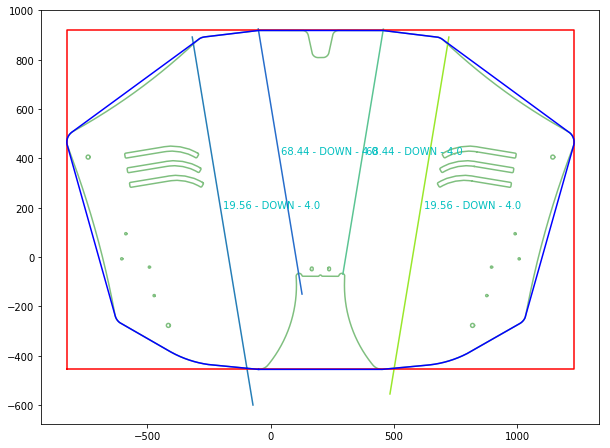

In [322]:
plot_dxf(details)

# Dataset creation

l1614570_flat1



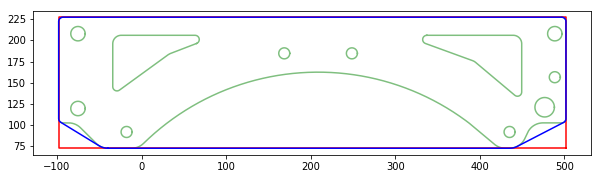

l1616010_flat1



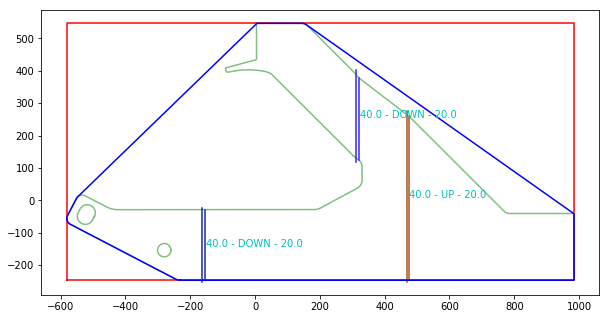

l1616170_flat1



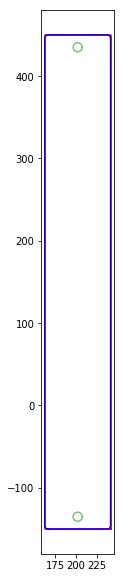

l2500700_flat1



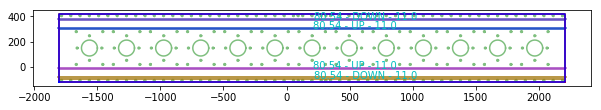

l2503310_flat1

NOK
NOK
NOK
NOK


/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: Mean of empty slice.
/Users/cricket/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


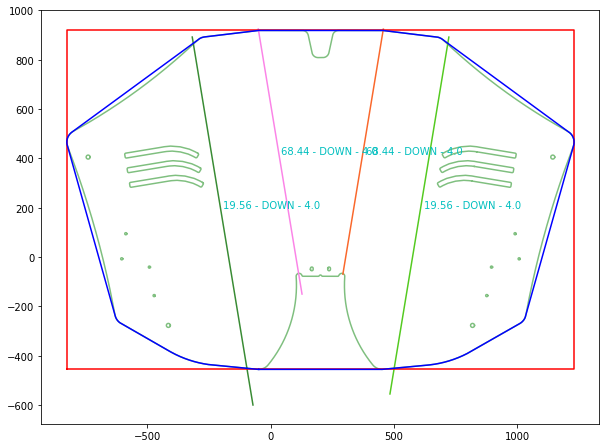

l2507330_flat1



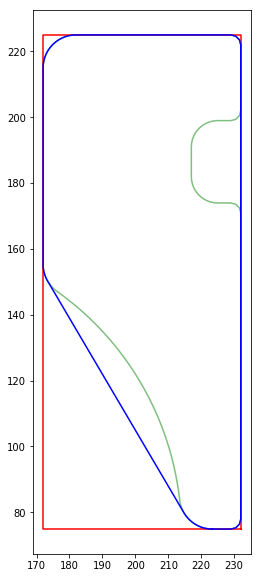

l2510670_flat1



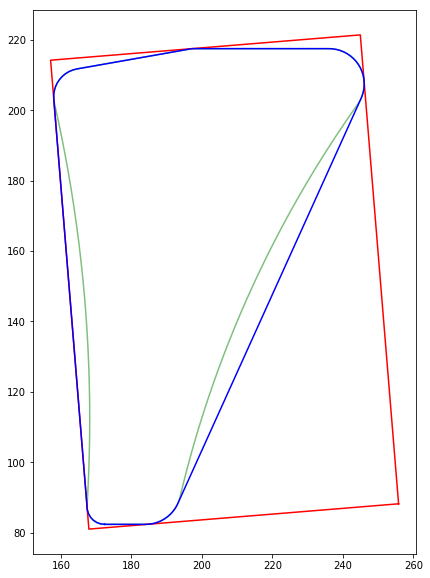

l2512270_flat1



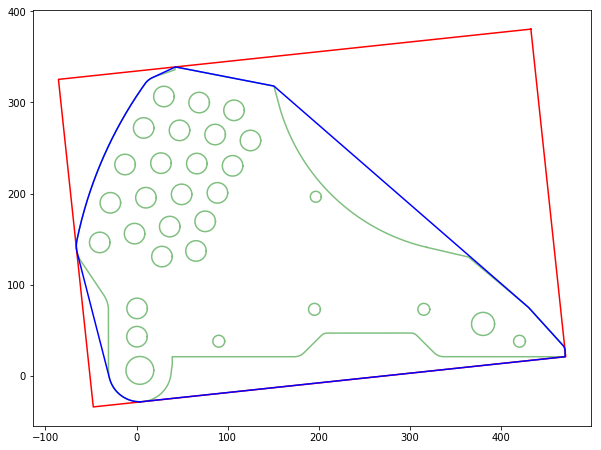

l2512980_flat1



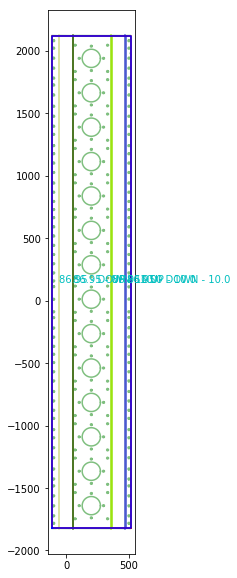

l2518910_flat1



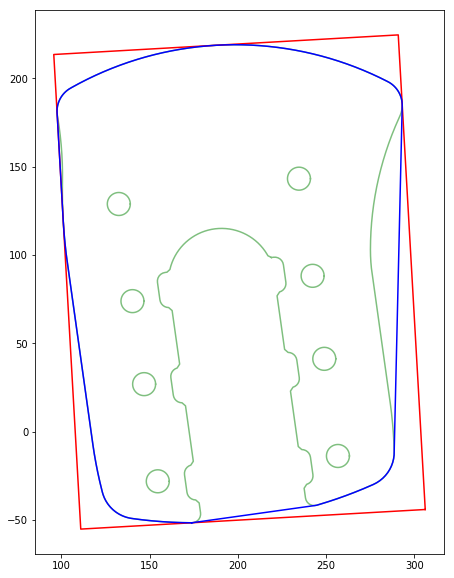

l2522110_flat1



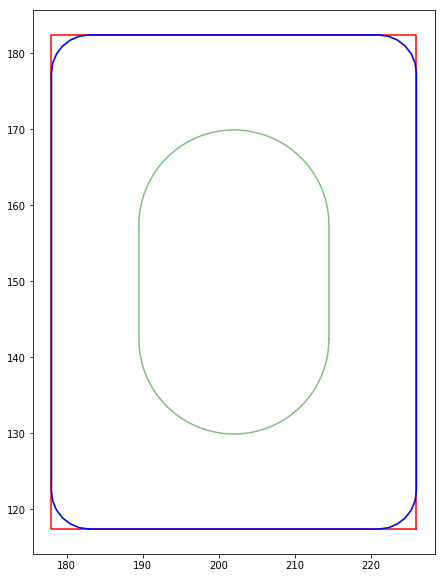

l2603320_flat1



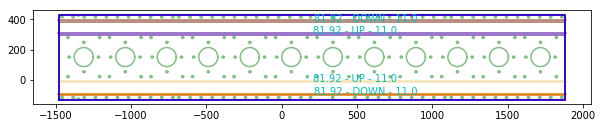

l2606540_flat1



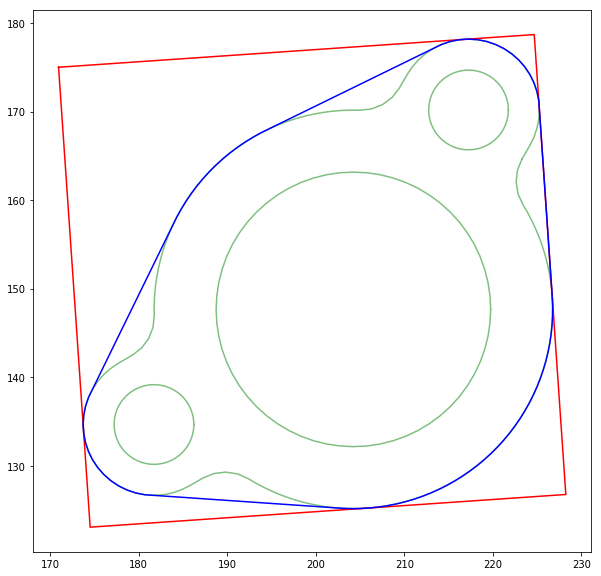

l2607640_flat1



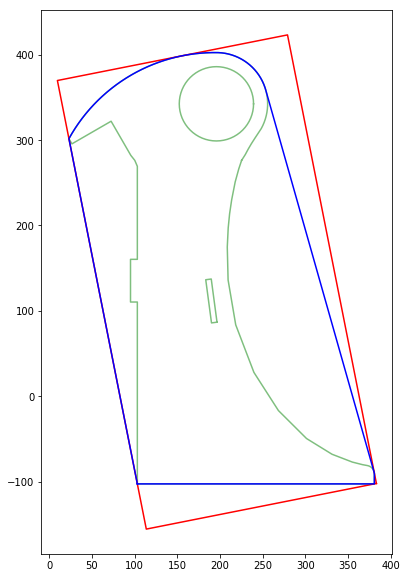

l2607690_flat1



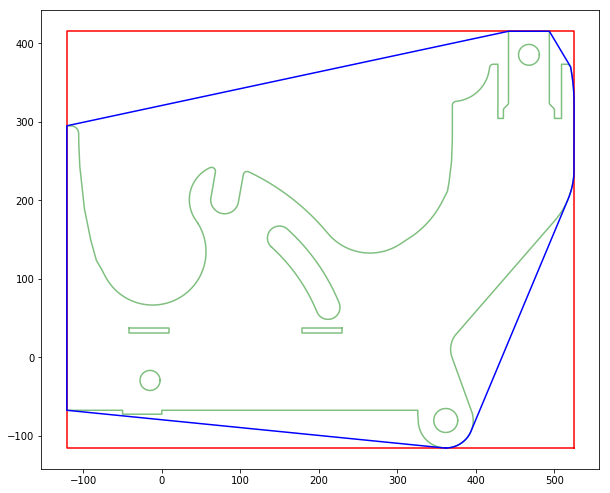

l2608450_flat1



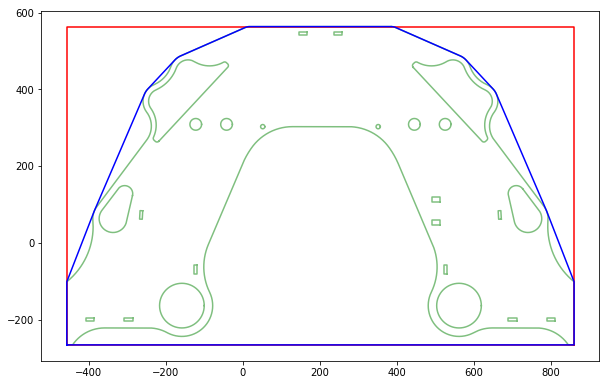

l2609830_flat1



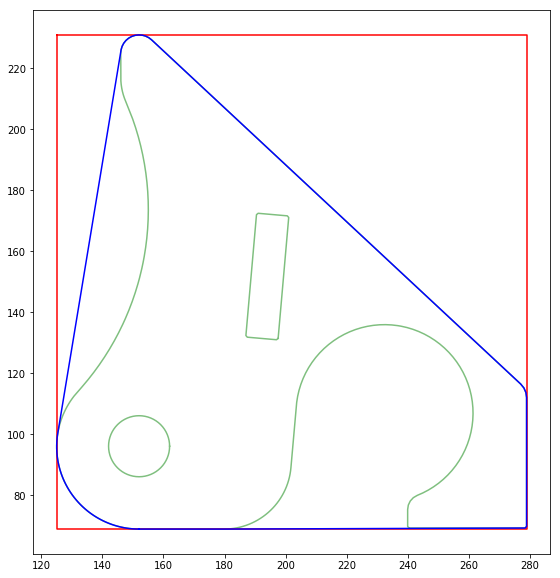

l2701680_flat1



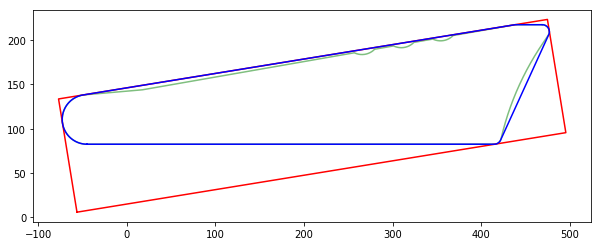

l2703550_flat1



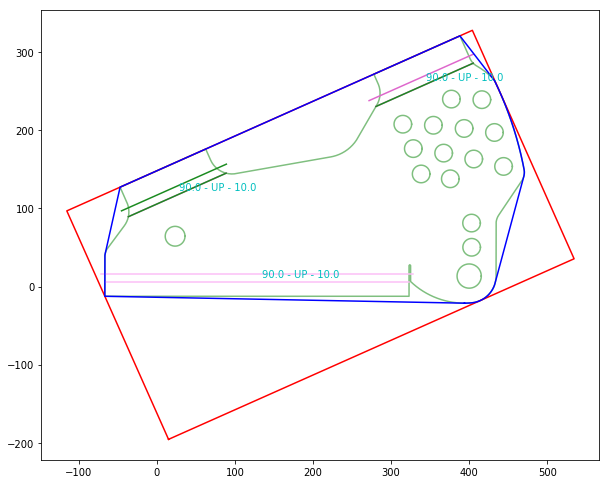

l3006650_flat1



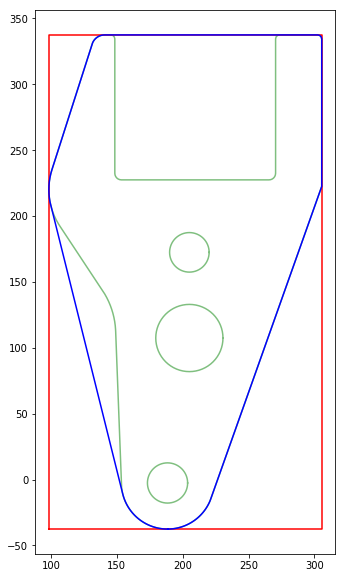

l3007020_flat1



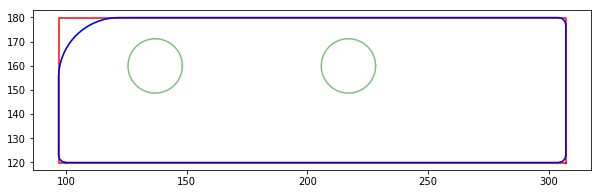

l3009013_flat1



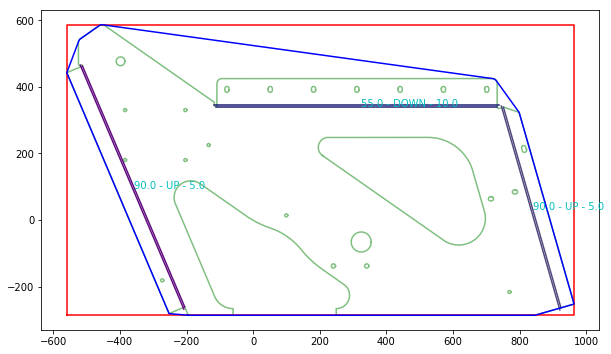

x0495337_flat1

NOK
NOK


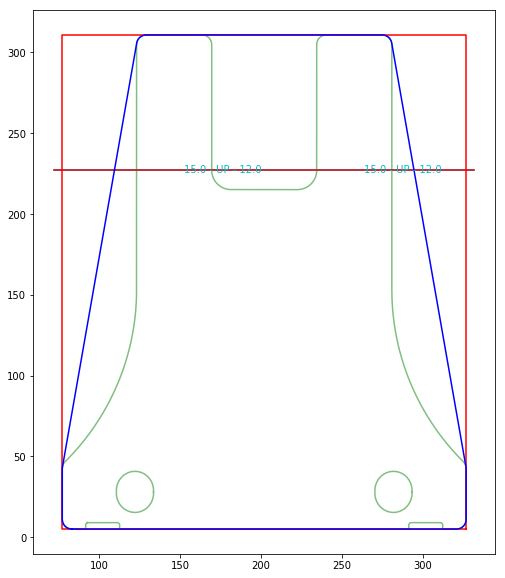

,index,project,cut_length,num_closed_patterns,num_open_patterns,total_area,minimum_rectangle_area,minimum_rectangle_dim1,minimum_rectangle_dim2,convex_hull_area,...,bend_direction,deformation_length,possible_imperfection,bend_bend_distance,bend_bend_angle,merged_bend,punch_length,bend_edge_distance,bend_edge_angle,bend_edge_length
0,l1614570_flat1,,2559.317447,12,0,5.461865e+04,9.300000e+04,600.000000,155.000000,9.114448e+04,...,[],[],NaN,[],[],[],[],[],[],[]
1,l1616010_flat1,,5147.257835,3,0,4.795804e+05,1.240949e+06,1565.293000,792.790000,7.987351e+05,...,"[UP, DOWN, DOWN]","[505.0627599251, 217.79, 253.5721239031]",NaN,"[[643.06533574747, 287.6085844836785], [643.06...","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0]]","[0, 0, 0]","[527.918, 227.79, 282.855]","[[164.05900000000003, 490.6600185810945, 489.8...","[[135.0, 74.99998270381688, 0.0, 90.0, 135.000...","[[348.95861072912356, 96.46497174104184, 108.4..."
2,l1616170_flat1,,1422.117655,3,0,4.779567e+04,4.800000e+04,600.000000,80.000000,4.798544e+04,...,[],[],NaN,[],[],[],[],[],[],[]
3,l2500700_flat1,,23765.303862,232,0,1.986171e+06,2.180896e+06,4009.000000,544.000000,2.180896e+06,...,"[DOWN, UP, UP, DOWN]","[4009.0, 4009.0, 4009.0, 4009.0]",NaN,"[[74.07296853024918, 387.82772993443274, 466.5...","[[0.0, 0.0, 0.0], [-0.0, -0.0, 0.0], [0.0, 0.0...","[0, 0, 0, 0]","[4019.0, 4019.0, 4019.0, 4019.0]","[[505.29299999999995, 0.0, 38.706999999999994,...","[[0.0, 90.0, 0.0, 90.0], [0.0, 90.0, 0.0, 90.0...","[[4009.0, 544.0, 4009.0, 544.0], [4009.0, 544...."
4,l2503310_flat1,,10668.424952,21,0,2.087388e+06,2.822381e+06,2055.321000,1373.207000,2.269188e+06,...,"[DOWN, DOWN, DOWN, DOWN]","[nan, nan, nan, nan]","[((-95.962, -450.535), (-312.771, 863.112)), (...","[[320.9300267295681, 344.933352149, 619.587956...","[[-3.594136620677091e-05, -161.25642513744327,...","[0, 0, 0, 0]","[1088.390223705634, 1511.033585157524, 1006.03...","[[375.49586273752743, 584.5483905794284, 3.088...","[[75.18711367444732, 50.85159748763385, 87.505...","[[135.72656381489955, 226.6178206981966, 217.5..."
5,l2507330_flat1,,401.481732,1,0,6.390919e+03,9.000000e+03,150.000000,60.000000,7.195028e+03,...,[],[],NaN,[],[],[],[],[],[],[]
6,l2510670_flat1,,378.203979,1,0,6.883709e+03,1.177401e+04,133.512414,88.186668,7.707285e+03,...,[],[],NaN,[],[],[],[],[],[],[]
7,l2512270_flat1,,3526.296578,31,0,8.732622e+04,1.884139e+05,521.312268,361.422403,1.224569e+05,...,[],[],NaN,[],[],[],[],[],[],[]
8,l2512980_flat1,,25084.417105,233,0,2.231227e+06,2.498242e+06,3947.000000,632.947000,2.498242e+06,...,"[DOWN, UP, UP, DOWN]","[3946.7925812612, 3946.7925812612, 3946.792581...","[((201.996, -78.58), (202.704, -78.617)), ((20...","[[121.34901552615486, 434.81579215397437, 543....","[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[0, 0, 0, 0]","[3956.792, 3956.792, 3957.0, 3957.0]","[[44.65700000000003, 11.159999999999968, 11.16...","[[0.0, 90.0, 90.0, 90.0, 90.0, 90.0, 0.0, 0.0,...","[[3796.938, 33.49700000000007, 92.752000000000..."
9,l2518910_flat1,,1483.423473,9,0,3.363883e+04,5.257082e+04,269.124986,195.339788,4.659951e+04,...,[],[],NaN,[],[],[],[],[],[],[]


In [306]:
#List of all the dixs in the folder
dxffolder = os.path.join('/', *os.getcwd().split('/')[:-1], 'Sample')
dxflist = [os.path.join(dxffolder, file) for file in os.listdir(dxffolder) if file.endswith('.dxf')]

columns = ['cut_length', 'num_closed_patterns', 'num_open_patterns', 'total_area', 'minimum_rectangle_area', 'minimum_rectangle_dim1', 'minimum_rectangle_dim2',
           'convex_hull_area', 'no_hole_area', 'thickness', 'unit', 'material', 'radius', 'bend_radius',
           'bend_angle', 'bend_direction', 'deformation_length', 'possible_imperfection', 'bend_bend_distance',
           'bend_bend_angle', 'merged_bend', 'punch_length',
           'bend_edge_distance', 'bend_edge_angle', 'bend_edge_length']

dataset = pd.DataFrame(columns = columns)
dxfparser = DxfParser(min_edge_length=1, roundigexp=3)
for dxffile in dxflist[:]:
    name = dxffile.split('/')[-1]
    name = name.split('.')[0]
    print(name)
    details = dxfparser.parse(dxffile)
    plot_dxf(details)
    dataset.loc[name] = [details.get(x, np.nan) for x in dataset.columns]
dataset.to_csv('../Sample/Z1 - dataset.csv')
dataset.reset_index()

To add in the dataset:
- DONE + rectangle area
- DONE + rectangle dimension (height and width)
- DONE + Main area (no holes)
- DONE + convex hull area (no holes)
- DONE + Add the forgivness parameter
- bends:
    - DONE + Radius
    - DONE + Placement relative to outside edges (Min length, number, distance)
    - DONE + placement relative to other bends (Distance, Angle)
    - NOT NEEDED + Extend version of the bend lines
    - DONE + Punch length
    - DONE + Angle
    - DONE + Direction
    - DONE + Length of deformation
- DONE + Number of open loops
- DONE + Number of closed loops
- DONE + Cut Length
- DONE + Thickness
- DONE + Material grade

In [307]:
dataset['project']

l1614570_flat1    
l1616010_flat1    
l1616170_flat1    
l2500700_flat1    
l2503310_flat1    
l2507330_flat1    
l2510670_flat1    
l2512270_flat1    
l2512980_flat1    
l2518910_flat1    
l2522110_flat1    
l2603320_flat1    
l2606540_flat1    
l2607640_flat1    
l2607690_flat1    
l2608450_flat1    
l2609830_flat1    
l2701680_flat1    
l2703550_flat1    
l3006650_flat1    
l3007020_flat1    
l3009013_flat1    
x0495337_flat1    
Name: project, dtype: object